In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as sk
from sklearn import svm
from sklearn.model_selection import train_test_split
import sklearn.tree as tree
import sklearn.ensemble as en
import sklearn.preprocessing as skp
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, classification_report
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn import preprocessing

In [2]:
# loading the data and picking out the necessary columns
data = pd.read_csv("OnlineNewsPopularity.csv")

le=preprocessing.LabelEncoder()
data["labels"] = pd.Series(le.fit_transform(data.iloc[:,-1]>=1400))


neededColumns = [" n_non_stop_unique_tokens", " num_hrefs", " num_self_hrefs", " num_imgs", " num_videos", 
                ' data_channel_is_lifestyle',
               ' data_channel_is_socmed',
               ' kw_avg_min', ' kw_avg_max', ' kw_avg_avg', ' self_reference_avg_sharess',
                ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
               ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
               ' weekday_is_sunday', 
               ' LDA_03',
               ' global_sentiment_polarity',
                ' rate_positive_words',
               ' rate_negative_words',
               ' title_sentiment_polarity', ' abs_title_subjectivity',
               'labels']

newData = data[neededColumns]

X = newData.iloc[:,0:len(neededColumns)-1]
y = newData.iloc[:,-1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
# A function to fit the model and print test accuracies
def modelfit(alg, dtrain, dy, dtest, dytest):
    #Fit the algorithm on the data
    alg.fit(dtrain, dy)
        
    #Predict training set:
    dtest_predictions = alg.predict(dtest)
    dtest_predprob = alg.predict_proba(dtest)[:,1]
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dytest, dtest_predictions))
    print("AUC Score: %f" % metrics.roc_auc_score(dytest, dtest_predprob))    

## BASELINE MODELS

### K-Nearest Neighbours

In [4]:
# Baseline model 1 - K-Nearest Neighbours with Default parameters
model = KNeighborsClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.5759
AUC Score: 0.590394


### Logistic Regression

In [5]:
# Baseline model 2 - Logisitic regression with default parameters
model = sk.LogisticRegression()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.5616
AUC Score: 0.605481


/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Support Vector Machine

In [6]:
# Baseline model 3 - SVM Classifier with default parameters
model= svm.SVC(kernel="rbf")
model.fit(Xtrain, np.array(ytrain).ravel())
pred = model.predict(Xtest)
print(metrics.roc_auc_score(ytest, pred))

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.5007514080766078


### AdaBoost

In [7]:
# Baseline model 4 - Adaboost with Default parameters
model = en.AdaBoostClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.6437
AUC Score: 0.694879


### Random Forest

In [8]:
# Baseline model 5 - RandomForest with Default parameters
model = en.RandomForestClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Model Report
Accuracy : 0.6035
AUC Score: 0.646661


### Gradient Boosting Classifier

In [9]:
# Baseline model 6 - Gradient boosting with Default parameters
model = en.GradientBoostingClassifier()
modelfit(model, Xtrain, ytrain, Xtest, ytest)


Model Report
Accuracy : 0.6471
AUC Score: 0.704359


In [10]:
Xtrain2 = Xtrain
Xtest2 = Xtest

### Optimizing the model hyper parameters

Accuracy of the GBM on test set: 0.648
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      6150
           1       0.65      0.72      0.68      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.64      0.64     13083
weighted avg       0.65      0.65      0.65     13083



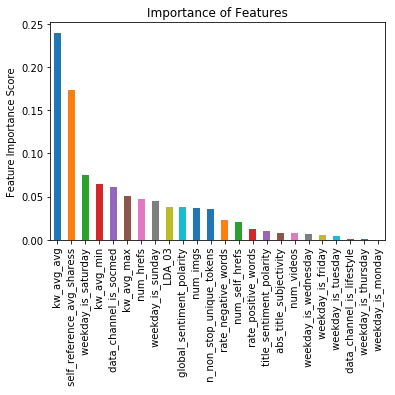

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV


baseline = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
baseline.fit(Xtrain2,ytrain)
predictors=list(Xtrain2)
feat_imp = pd.Series(baseline.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(baseline.score(Xtest2, ytest)))
pred=baseline.predict(Xtest2)
print(classification_report(ytest, pred))

In [13]:
# optimising learning rate and n_estimators
p_test3 = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'n_estimators':[100,250,500,750,1000,1250,1500,1750]}

tuning = GridSearchCV(estimator = GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain2,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/an

({'mean_fit_time': array([ 1.80219779,  3.87972722,  8.08753633, 12.21786561, 15.52905526,
         20.67868142, 32.57704835, 29.48347812,  1.68459692,  4.59079695,
          8.28178844, 12.41457858, 15.51725898, 19.09118395, 25.69688983,
         32.27430301,  1.99291883,  3.72659483,  7.11471682, 11.30536146,
         15.66251159, 19.32491112, 23.28855038, 26.76893859,  1.71731329,
          4.2445683 ,  8.77814331, 12.29031024, 15.64362745, 21.95250406,
         24.34976077, 27.72787704,  1.90806928,  4.27677641,  8.56929126,
         12.41506667, 18.17652712, 21.27477503, 26.93897433, 34.81951027,
          1.9316503 ,  5.17556939, 10.48409524, 13.73569398, 19.62419434,
         25.31440587, 27.37920189, 29.02590261]),
  'std_fit_time': array([0.07344157, 0.08584479, 0.48031979, 0.28447198, 0.31360028,
         0.40116159, 4.07509722, 1.90467828, 0.16118442, 0.17762014,
         0.10166979, 0.24901563, 0.15780543, 0.67091213, 0.53821518,
         2.46746562, 0.11141226, 0.12798315,

In [14]:
# optimising max_depth parameter
p_test2 = {'max_depth':[2,3,4,5,6,7] }
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1750, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
            param_grid = p_test2, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain2,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/an

({'mean_fit_time': array([13.481144  , 20.787181  , 28.69200873, 39.09917002, 54.02593193,
         60.91325788]),
  'std_fit_time': array([0.08875035, 0.87734935, 0.16092545, 0.30843075, 2.50482217,
         9.73105081]),
  'mean_score_time': array([0.13633718, 0.16599822, 0.2146122 , 0.29207935, 0.29278808,
         0.30346832]),
  'std_score_time': array([0.00676795, 0.0037324 , 0.01368246, 0.05485787, 0.00513968,
         0.03561791]),
  'param_max_depth': masked_array(data=[2, 3, 4, 5, 6, 7],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 2},
   {'max_depth': 3},
   {'max_depth': 4},
   {'max_depth': 5},
   {'max_depth': 6},
   {'max_depth': 7}],
  'split0_test_score': array([0.65330322, 0.65650292, 0.65669113, 0.65556183, 0.65819688,
         0.65687935]),
  'split1_test_score': array([0.65700301, 0.65813253, 0.65869729, 0.66170934, 0.65963855,
         0.66246235]),
  'split2_test_s

Accuracy of the GBM on test set: 0.653
AUC Score: 0.710577
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6150
           1       0.66      0.72      0.69      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.65      0.65      0.65     13083



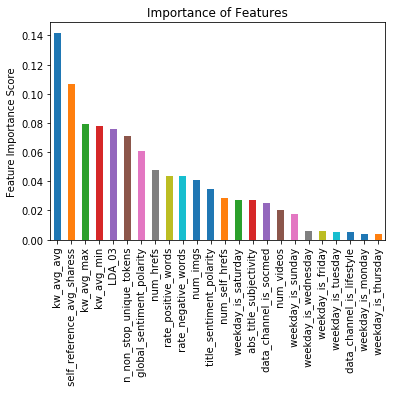

In [15]:
# fitting a model with the optimised parameters
model1 = en.GradientBoostingClassifier(learning_rate=0.01,n_estimators=1750, max_depth=7, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10)
model1.fit(Xtrain2,ytrain)
predictors=list(Xtrain2)
feat_imp = pd.Series(model1.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model1.score(Xtest2, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model1.predict_proba(Xtest2)[:,1]))
pred=model1.predict(Xtest2)
print(classification_report(ytest, pred))

In [16]:
# optimising max_features parameter
p_test5 = {'max_features':[5,6,7,8,9,10,11]}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1750, max_depth=7, min_samples_split=2, min_samples_leaf=1, subsample=1, random_state=10), 
param_grid = p_test5, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain2,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/an

({'mean_fit_time': array([ 78.14811296,  89.85443873, 105.49097056, 114.76288776,
         125.75852928, 136.59676132, 130.64626684]),
  'std_fit_time': array([ 0.96278278,  1.46145978,  2.77759892,  1.29225183,  1.64896406,
          2.57627783, 14.54644703]),
  'mean_score_time': array([0.33873968, 0.36320162, 0.34557338, 0.34393387, 0.33556523,
         0.34742398, 0.29286652]),
  'std_score_time': array([0.01259245, 0.02663043, 0.01335471, 0.00953394, 0.01096494,
         0.00729193, 0.03653637]),
  'param_max_features': masked_array(data=[5, 6, 7, 8, 9, 10, 11],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 5},
   {'max_features': 6},
   {'max_features': 7},
   {'max_features': 8},
   {'max_features': 9},
   {'max_features': 10},
   {'max_features': 11}],
  'split0_test_score': array([0.65236213, 0.65292678, 0.65480896, 0.65160926, 0.6563147 ,
         0.65292678, 0.6527385

Accuracy of the GBM on test set: 0.650
AUC Score: 0.710165
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6150
           1       0.66      0.72      0.69      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.65      0.65      0.65     13083



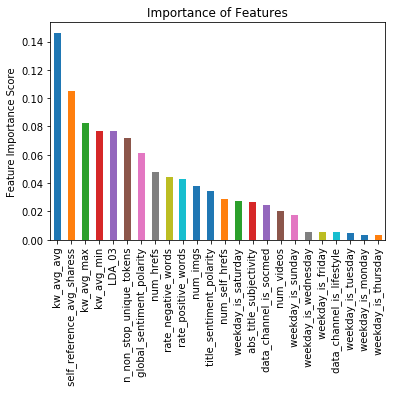

In [18]:
# building a model after tuning the parameters to check test accuracies
model2 = GradientBoostingClassifier(learning_rate=0.01,n_estimators=1750, max_features=5, max_depth=7, min_samples_split=2, min_samples_leaf=1, subsample=1, random_state=10)
model2.fit(Xtrain2,ytrain)
predictors=list(Xtrain2)
feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model2.score(Xtest2, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model2.predict_proba(Xtest2)[:,1]))
pred=model1.predict(Xtest2)
print(classification_report(ytest, pred))

In [19]:
# tuning max_depth parameter with the new model
p_test6= {'max_depth':list(range(1,11,1))}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01,n_estimators=1750, max_features=5, min_samples_split=2, min_samples_leaf=1, subsample=1, random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain2,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/an

({'mean_fit_time': array([ 52.67605481, 140.93790479,  22.64432373,  39.9801754 ,
          43.52172418,  77.47996569, 108.10833631, 141.93781204,
         169.23069229, 271.50940204]),
  'std_fit_time': array([ 82.17741252, 102.06864472,   1.29530454,   2.35595452,
           2.39382149,   5.39763244,   1.98500426,  11.04479886,
           6.18565888,  52.4716087 ]),
  'mean_score_time': array([0.07573886, 0.12217979, 0.22022185, 0.22777996, 0.2598938 ,
         0.35839458, 0.42979765, 0.44114223, 0.56071358, 0.66682086]),
  'std_score_time': array([0.009737  , 0.00518933, 0.05068683, 0.04155509, 0.0476518 ,
         0.03489746, 0.04046526, 0.03146012, 0.10568385, 0.22913821]),
  'param_max_depth': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_depth': 1},
   {'max_depth': 2},
   {'max_depth': 3},


Accuracy of the GBM on test set: 0.651
AUC Score: 0.710384
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6150
           1       0.66      0.72      0.68      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.65      0.65      0.65     13083



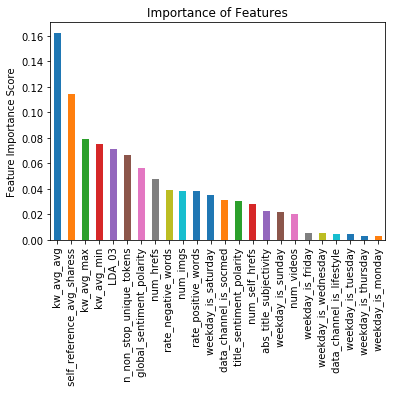

In [20]:
# new model after tuning the parameters to check test accuracies
model2 = en.GradientBoostingClassifier(learning_rate=0.01, n_estimators=1750, max_depth=6, max_features=5, min_samples_split=2, min_samples_leaf=1, subsample=1, random_state=10)
model2.fit(Xtrain2,ytrain)
predictors=list(Xtrain2)
feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model2.score(Xtest2, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model2.predict_proba(Xtest2)[:,1]))
pred=model2.predict(Xtest2)
print(classification_report(ytest, pred))

In [21]:
# tuning the subsample parameter
p_test6= {'subsample':np.arange(0.1,1,0.1)}
tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1750, max_depth=6, max_features=5, min_samples_split=2, min_samples_leaf=1, random_state=10), 
param_grid = p_test6, scoring='accuracy',n_jobs=4,iid=False, cv=5)
tuning.fit(Xtrain2,np.array(ytrain).ravel())
tuning.cv_results_, tuning.best_params_, tuning.best_score_

/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/dhivyaslh/anaconda3/lib/pytho

({'mean_fit_time': array([32.79618759, 39.1069643 , 43.34078178, 47.91540198, 59.37945905,
         70.59106774, 76.71055212, 70.42291493, 55.43048735]),
  'std_fit_time': array([0.36041522, 0.48071112, 0.22039845, 0.19632583, 5.82609684,
         3.58195467, 4.1442175 , 4.62423168, 8.02450085]),
  'mean_score_time': array([0.30717688, 0.29706869, 0.31332664, 0.29516582, 0.40119843,
         0.37541285, 0.45961065, 0.33777966, 0.25724416]),
  'std_score_time': array([0.00593164, 0.00223728, 0.02275724, 0.00242553, 0.07389094,
         0.04003491, 0.06923173, 0.06622462, 0.04096216]),
  'param_subsample': masked_array(data=[0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6,
                     0.7000000000000001, 0.8, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.1},
   {'subsample': 0.2},
   {'subsample': 0.30000000000000004},
   {'subsample':

Accuracy of the GBM on test set: 0.651
AUC Score: 0.710916
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6150
           1       0.66      0.71      0.68      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.65      0.65      0.65     13083



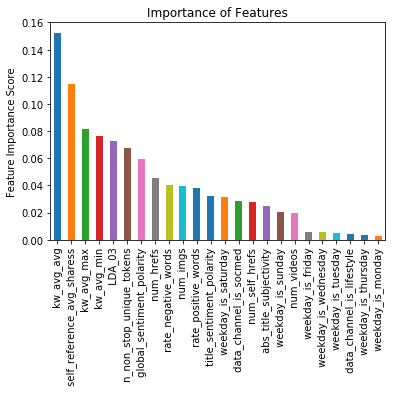

In [23]:
# new model based on tuned parameters to check test accuracies
model2 = en.GradientBoostingClassifier(learning_rate=0.01, n_estimators=1750, subsample=0.9, max_depth=6, max_features=5, min_samples_split=2, min_samples_leaf=1, random_state=10)
model2.fit(Xtrain2,ytrain)
predictors=list(Xtrain2)
feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model2.score(Xtest2, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model2.predict_proba(Xtest2)[:,1]))
pred=model2.predict(Xtest2)
print(classification_report(ytest, pred))

In [24]:
# Function to get X with polynomial features of a given degree
def getPolynomialX(degree, X):
    poly_quadratic = skp.PolynomialFeatures(degree)
    X = poly_quadratic.fit_transform(pd.DataFrame(X))
    return X

In [25]:
# three degree polynomial feature set data
Xtrain3 = getPolynomialX(3, Xtrain2)
Xtest3 = getPolynomialX(3, Xtest2)

Accuracy of the GBM on test set: 0.650
AUC Score: 0.704493
              precision    recall  f1-score   support

           0       0.64      0.58      0.61      6150
           1       0.66      0.71      0.68      6933

   micro avg       0.65      0.65      0.65     13083
   macro avg       0.65      0.65      0.65     13083
weighted avg       0.65      0.65      0.65     13083



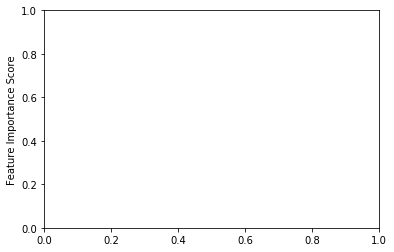

In [26]:
# new model with tuned parameters and polynomial data to check the test accuracies
model2 = en.GradientBoostingClassifier(learning_rate=0.01, n_estimators=1750, subsample=0.9, max_depth=6, max_features=5, min_samples_split=2, min_samples_leaf=1, random_state=10)
model2.fit(Xtrain3,ytrain)
predictors=list(Xtrain3)
# feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model2.score(Xtest3, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model2.predict_proba(Xtest3)[:,1]))
pred=model2.predict(Xtest3)
print(classification_report(ytest, pred))

In [27]:
# four degree polynomial feature set data
Xtrain4 = getPolynomialX(4, Xtrain2)
Xtest4 = getPolynomialX(4, Xtest2)

Accuracy of the GBM on test set: 0.627
AUC Score: 0.676354
              precision    recall  f1-score   support

           0       0.61      0.57      0.59      6150
           1       0.64      0.68      0.66      6933

   micro avg       0.63      0.63      0.63     13083
   macro avg       0.63      0.62      0.62     13083
weighted avg       0.63      0.63      0.63     13083



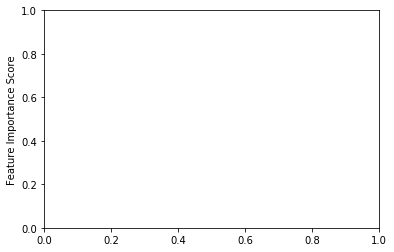

In [28]:
# new model with tuned parameters and polynomial data to check the test accuracies
model2 = en.GradientBoostingClassifier(learning_rate=0.005, subsample=0.2, n_estimators=750, min_samples_split=2, min_samples_leaf=1,max_features=6, random_state=10)
model2.fit(Xtrain4,ytrain)
predictors=list(Xtrain4)
# feat_imp = pd.Series(model2.feature_importances_, predictors).sort_values(ascending=False)
# feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')
print('Accuracy of the GBM on test set: {:.3f}'.format(model2.score(Xtest4, ytest)))
print("AUC Score: %f" % metrics.roc_auc_score(ytest, model2.predict_proba(Xtest4)[:,1]))
pred=model2.predict(Xtest4)
print(classification_report(ytest, pred))

## Gradient boosting model with parameters learning_rate = 0.01, n_estimators = 1750 seems to perform the best for determining popularity of an article